In [1]:
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib as mpl

from type3detect import detectRadioburst as drb

%load_ext autoreload
%autoreload 2

In [2]:
fname  = './LOFAR_20220701_070000_LBA_OUTER_S0.fits'

(dyspec,t_fits,f_fits,hdu)  = drb.read_fits(fname)
(dyspec,f_fits) =  drb.cut_low(dyspec,f_fits,f_low_cut_val=30)

Text(0.5, 1.0, '2022/07/01 LOFAR LBA_OUTER STOKES_0')

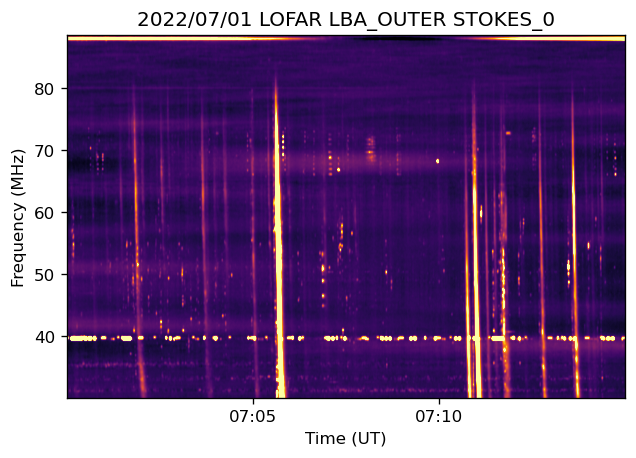

In [3]:
(data_fits_new_tmp,data_fits_new) = drb.preproc(dyspec,gauss_sigma=1.5)

fig = plt.figure(figsize=(6, 4), dpi=120)
ax = plt.gca()

data_safe_arr = data_fits_new.ravel()
data_safe = np.sort(data_safe_arr)[int(data_safe_arr.shape[0] * 0.02):int(data_safe_arr.shape[0] * 0.98)]
vmin,vmax = [(np.nanmean(data_safe) - 2 * np.nanstd(data_safe)),
                  (np.nanmean(data_safe) + 4 * np.nanstd(data_safe)+0.5*np.nanmax(data_safe))]
        
ax.imshow(data_fits_new.T,aspect='auto',  origin='lower', vmax=vmax,vmin=vmin,
                   extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]],cmap='inferno')

ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(hdu[0].header['CONTENT'])

## Binarization Local max 

Threshold: $$I> I_{thresh}$$

Local-max: $$ I_{i-1}< I_{i}> I_{i+1} $$

Second order Local-max: $$ I_{i-2}< I_{i-1}< I_{i}> I_{i+1}> I_{i+2} $$

Second order Local-max with ratio R=1.2: $$ R^2 \times I_{i-2}< R \times I_{i-1}< I_{i}> R\times I_{i+1}> R^2 \times I_{i+2} $$


In [4]:
# binarization
bmap = drb.binarization(data_fits_new,N_order=6,peak_r=1.002)

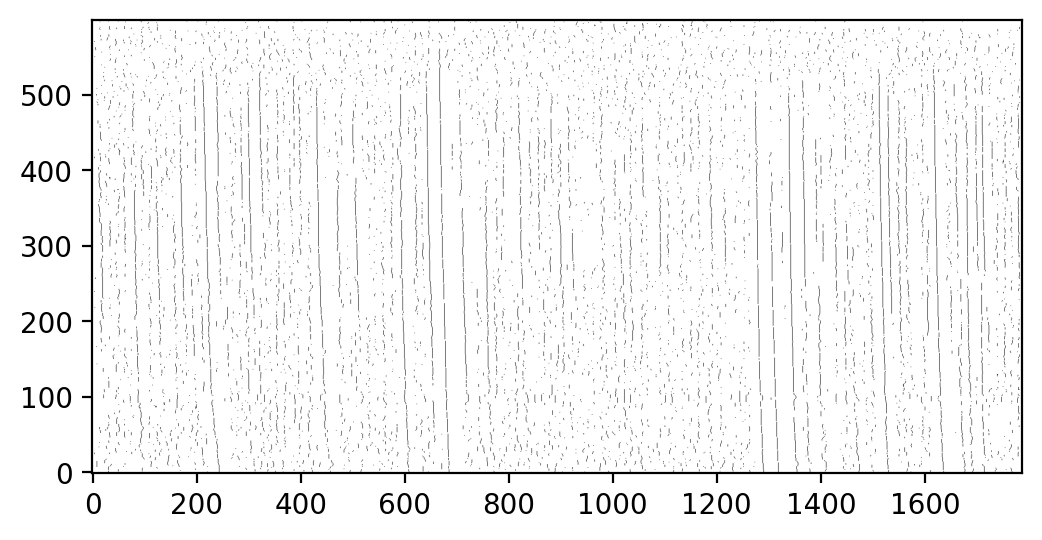

In [5]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
ax.imshow(1-bmap.T,aspect='auto', origin='lower',cmap='gray')

Text(0.5, 1.0, 'overplot binary map to spectrum')

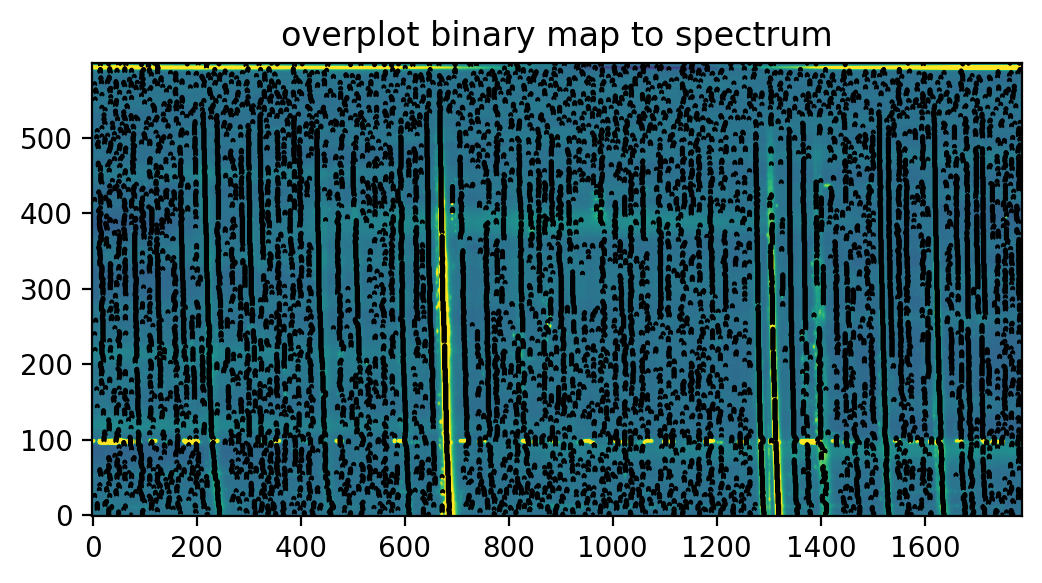

In [6]:
fig = plt.figure(figsize=[6,3],dpi=200)
plt.imshow(data_fits_new.T,aspect='auto',origin='lower',vmax=vmax,vmin=vmin/2-vmax/2)
plt.contour(bmap.T,[0,0.5,1],colors='k')
plt.title("overplot binary map to spectrum")

## Hough transform

Identify type-III (line-like features) in the image using the Hough transform.

In [7]:
# detect verticle features
lines = drb.hough_detect(bmap,dyspec,threshold=40,line_gap=10,line_length=30,
            theta=np.linspace(np.pi/2-np.pi/8,np.pi/2-1/180*np.pi,300))

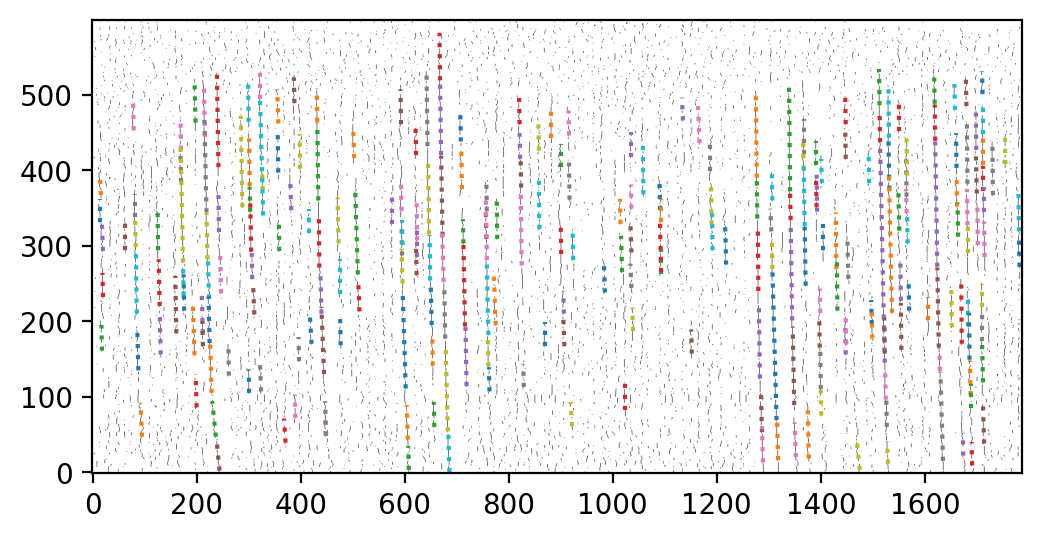

In [8]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
lines = sorted(lines, key=lambda i: i[0][1])
ax.imshow(1-bmap.T,aspect='auto',origin='lower',cmap='gray')
for line in lines:
    p0,p1= line
    ax.plot( (p0[1], p1[1]),(p0[0], p1[0]),':')


In [9]:
line_sets = drb.line_grouping(lines)
# group the detected lines into group in regard of events

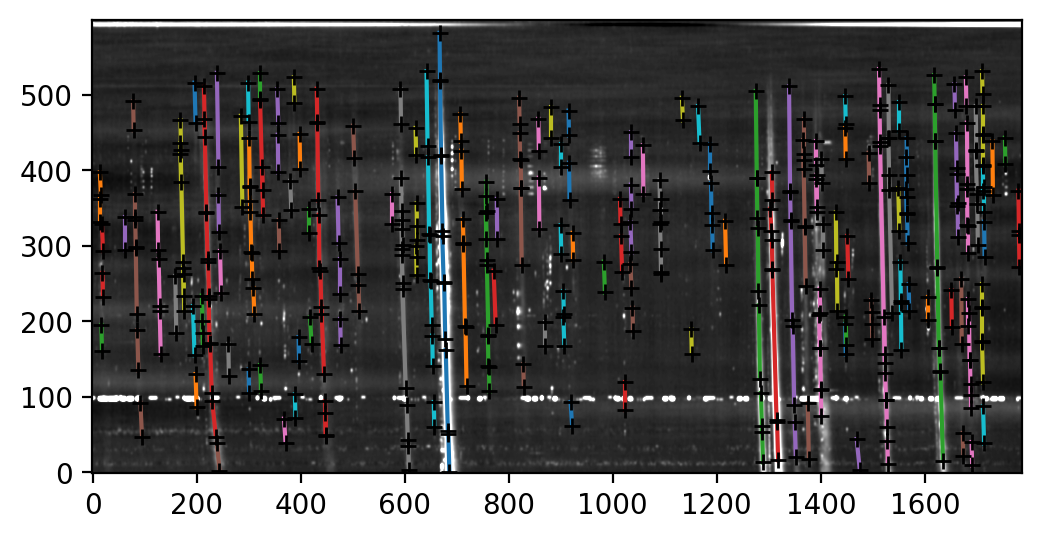

In [10]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
ax.imshow(data_fits_new.T,aspect='auto',origin='lower',vmax=vmax,vmin=vmin,cmap='gray')

for idx,lines in enumerate(line_sets):
    for line in lines:
        p0,p1= line
        ax.plot( (p0[1], p1[1]),(p0[0], p1[0]),color='C'+str(idx+1))
        ax.plot( (p0[1], p1[1]),(p0[0], p1[0]),'k+',zorder=10)
    #ax.set_xlim((500,600))
#ax.set_ylim((bmap.shape[0], 0))

## Model the electron beam

To describe the t and f points in the radio burst.

Model a electron beam going outward with a speed of v_{beam}, with a starting time $t_0$, we can have r(t).

With a density model:

$$N_e(r) = 4.8\times 10^9/r^{14} + 3\times 10^8/r^6+1.39\times 10^6/r^{2.3}+n_0 $$

And $f=8.93\times 10^3 \sqrt{N_e}$

We can have a f(t) from the model, which is the frequency drift line.

The modeling procedure is to find a combination of $[v_{beam},t_0]$ to make the output of the model f(t) fit best to the data points above

In [11]:
from type3detect import radioTools as rt

In [12]:
#(rt.freq_to_R(20e6)-rt.freq_to_R(80e6))/rt.c_r

In [13]:
(v_beam, f_range_burst, t_range_burst, model_curve_set,
     t_set_arr_set,f_set_arr_set,t_model_arr,f_model_arr
    )= drb.get_info_from_linegroup(line_sets,t_fits,f_fits)

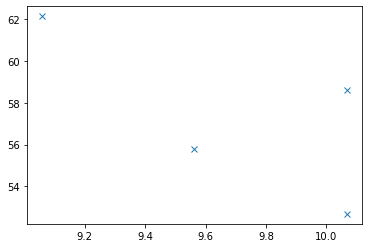

In [14]:
plt.plot(t_set_arr_set[0],f_set_arr_set[0],'x')

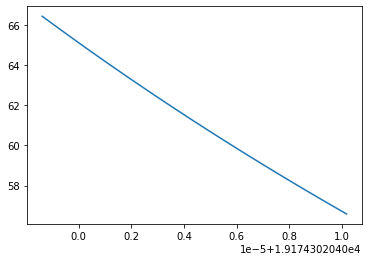

In [15]:
plt.plot(t_model_arr,f_model_arr)

In [16]:
line_sets

[[((332, 14), (362, 14)), ((367, 16), (397, 14))],
 [((161, 18), (195, 17))],
 [((232, 20), (264, 19)), ((293, 20), (329, 18))],
 [((294, 63), (338, 63))],
 [((453, 79), (491, 78)),
  ((338, 81), (368, 81)),
  ((298, 83), (334, 82)),
  ((210, 85), (297, 83)),
  ((135, 88), (188, 86)),
  ((47, 95), (92, 92))],
 [((294, 126), (345, 125)),
  ((220, 129), (282, 127)),
  ((156, 131), (214, 129))],
 [((184, 161), (260, 159))],
 [((427, 170), (466, 169)),
  ((384, 170), (422, 169)),
  ((278, 174), (436, 169)),
  ((234, 175), (271, 174)),
  ((214, 176), (262, 175))],
 [((155, 196), (220, 193))],
 [((463, 198), (516, 196))],
 [((86, 200), (130, 198))],
 [((184, 212), (234, 210)), ((167, 212), (200, 211))],
 [((444, 216), (512, 214)),
  ((344, 219), (468, 215)),
  ((282, 221), (343, 219)),
  ((230, 224), (279, 222)),
  ((171, 225), (233, 223)),
  ((105, 229), (170, 226)),
  ((47, 237), (94, 230))],
 [((404, 242), (529, 239)), ((318, 243), (367, 242))],
 [((2, 244), (39, 239))],
 [((237, 247), (2

Text(0.5, 1.0, '2022/07/01 LOFAR LBA_OUTER STOKES_0')

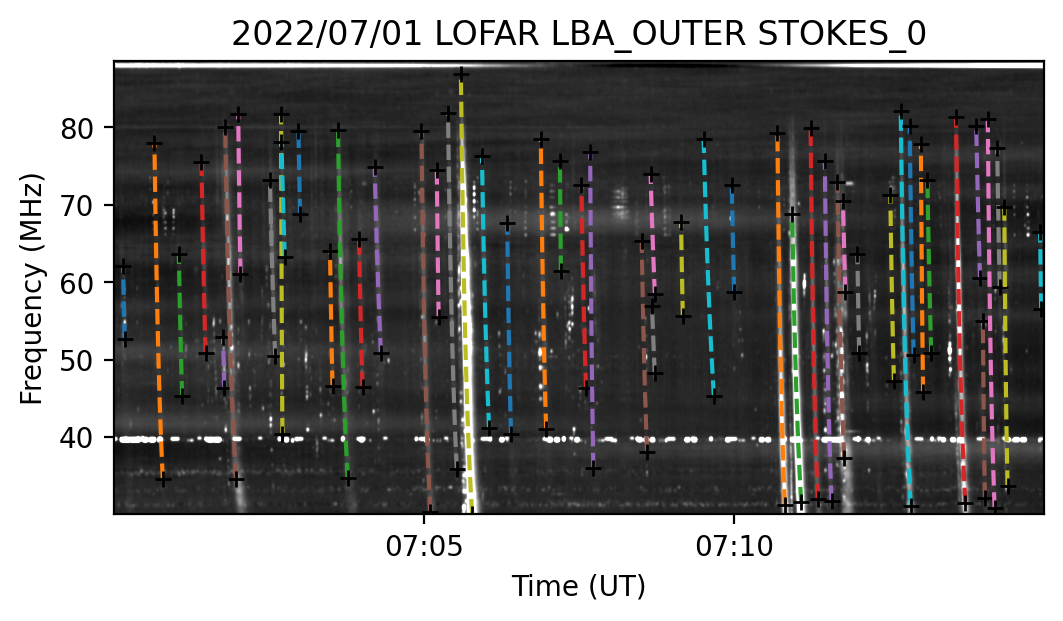

In [17]:
fig,ax = plt.subplots(1,1,figsize=[6,3],dpi=200)
lines = sorted(lines, key=lambda i: i[0][1])
ax.imshow(data_fits_new.T,aspect='auto',origin='lower', vmax=vmax,vmin=vmin,cmap='gray',
                   extent=[t_fits[0],t_fits[-1],f_fits[0],f_fits[-1]])
for idx,model in enumerate(model_curve_set):
    if (v_beam[idx] > 0) and (v_beam[idx] < 0.9):
        plt.plot(model[0],model[1],ls='--')
        plt.plot(t_range_burst[idx],f_range_burst[idx],'k+')
    


ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(hdu[0].header['CONTENT'])


#ax.set_xlim([t_fits[200],t_fits[400]])
#plt.ylim([10,88])


In [18]:
# dump information to Json file
import json

In [19]:
fname_json  = fname.replace('.fits','.json')

In [20]:
with open(fname_json, 'r') as fp:
    dict_old = json.load(fp)
fp.close()

In [21]:
(t_range_burst[0][1]-t_range_burst[0][0])*3600*24

-1.6021551098674536

In [22]:
dict_old

{'telescope': 'LOFAR',
 'instrume': 'LBA_OUTER',
 'projectID': 'IDOLS',
 'obsID': '865080',
 'source': './H5/L865080_SAP000_B000_S0_P000_bf.h5',
 'date': '2022-07-01',
 'ra': 0.0,
 'dec': 0.0,
 'x': 363203.22706666234,
 'y': -66899.44080970963,
 'time': '07:00:00.000000',
 'event': {'no_detection': True, 'type': 'none', 'level': 'none'},
 'n_freq': 800,
 'n_time': 1788,
 'freq_range': [10.491943359375, 88.519287109375],
 'time_range': ['2022-07-01 07:00:00.000000', '2022-07-01 07:15:00.000000']}

In [23]:
event_detail = []
for idx,v_cur in enumerate(v_beam):
    event_detail.append({
        'v_beam':v_cur,
        'freq_range':((f_range_burst[idx])),
        'time_range':((t_range_burst[idx])),
        'str_time':mdates.num2date(t_range_burst[idx][0]).strftime("%H:%M:%S")})

In [24]:
dict_old['event']={
    'detection': True,
    'type':'III',
    'detail': event_detail
}

In [25]:
dict_old

{'telescope': 'LOFAR',
 'instrume': 'LBA_OUTER',
 'projectID': 'IDOLS',
 'obsID': '865080',
 'source': './H5/L865080_SAP000_B000_S0_P000_bf.h5',
 'date': '2022-07-01',
 'ra': 0.0,
 'dec': 0.0,
 'x': 363203.22706666234,
 'y': -66899.44080970963,
 'time': '07:00:00.000000',
 'event': {'detection': True,
  'type': 'III',
  'detail': [{'v_beam': 0.0813418933958671,
    'freq_range': [52.679443359375, 62.152099609375],
    'time_range': [19174.2917911422, 19174.29177259874],
    'str_time': '07:00:10'},
   {'v_beam': 0.08540784396712452,
    'freq_range': [34.613037109375, 77.972412109375],
    'time_range': [19174.292217781225, 19174.29212433516],
    'str_time': '07:00:47'},
   {'v_beam': 0.08753133585232911,
    'freq_range': [45.257568359375, 63.714599609375],
    'time_range': [19174.29243450985, 19174.292397356214],
    'str_time': '07:01:06'},
   {'v_beam': 0.07508166279580518,
    'freq_range': [50.921630859375, 75.531005859375],
    'time_range': [19174.292696589786, 19174.29265081

In [26]:
with open('test.json', 'w') as fp:
     json.dump(dict_old,fp)
fp.close()

In [27]:
# write all events to a event list

import os
csv_fname = 'event.csv'
os.system('rm '+csv_fname)
id_event  = 0
with open(csv_fname,'w') as fp:
    fp.write('''ID, t, t0_num, t1_num,f_0,f_1, dfdt(MHz/s), v_b(c)
             ''')

with open(csv_fname,'a') as fp:
    
    for idx,v_cur in enumerate(v_beam):
        fp.write(str(id_event)+','+mdates.num2date(t_range_burst[idx][0]).strftime("%y-%m-%d %H:%M:%S")+','
             +str(t_range_burst[idx][0])+','+str(t_range_burst[idx][1])+','
             +str(f_range_burst[idx][0])+','+str(f_range_burst[idx][1])+','
             +str((np.max(f_set_arr_set[idx])-np.min(f_set_arr_set[idx]))/
             (np.max(t_set_arr_set[idx])-np.min(t_set_arr_set[idx])))+','
             +str(v_beam[idx])
             +'''
             ''')
        id_event+=1
fp.close()

In [28]:

os.system('pwd')

1

In [29]:
import glob

In [30]:
glob.glob('L*')

['LOFAR_20220701_070000_LBA_OUTER_S0.fits',
 'LOFAR_20220701_070000_LBA_OUTER_S0.json']